# Library

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [2]:
import random
import numpy as np
import tensorflow as tf

seed = 555

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Parameters

In [3]:
ticker = "AAPL"
lag = 10
start_date = "2018-01-01"
end_date = "2023-04-04"
train_test_ratio = 0.9
num_epochs = 200

# Functions

## Data

### Finance Data

In [4]:
def prep_finance(ticker, start_date="2018-01-01", end_date="2023-04-04"): # create_multi_df
    # Load data
    tickerData = yf.Ticker(ticker)
    tickerDF = tickerData.history(period="1d", start=start_date, end=end_date)

    # cut some variables
    tickerDF = tickerDF.drop("Dividends", axis=1)
    tickerDF = tickerDF.drop("Stock Splits", axis=1)

    # add control variables
    tickerDataDJI = yf.Ticker('^DJI')
    tickerDFDJI = tickerDataDJI.history(period='1d', start=start_date, end=end_date)
    # tickerDFDJI['DJI_Lag1'] = tickerDFDJI['Close'].shift(1)
    # tickerDF = pd.merge(tickerDF, tickerDFDJI['DJI_Lag1'], left_index=True, right_index=True)
    tickerDFDJI['DJI'] = tickerDFDJI['Close']
    tickerDF = pd.merge(tickerDF, tickerDFDJI['DJI'], left_index=True, right_index=True)

    # delete na rows
    tickerDF = tickerDF.dropna()
    
    return tickerDF

### Text Data

In [5]:
finbert_path = "/content/output_FinBert_final.xlsx"
textblob_path = "/content/output_TextBlob.xlsx"
vader_path = "/content/output_VADER.xlsx"
flair_path = "/content/Result_Flair_v1.xlsx"

In [6]:
finbert = pd.read_excel(finbert_path, index_col=0)
finbert = finbert.drop(["Neutral"], axis=1) # avoid multicollinearity
finbert = finbert.rename(columns={'Positive': 'finbert_pos', 'Negative': 'finbert_neg'})

textblob = pd.read_excel(textblob_path, index_col=0)

vader = pd.read_excel(vader_path, index_col=0)
vader = vader.drop(["vader_neu", "vader_pos", "vader_neg"], axis=1) # avoid multicollinearity

flair = pd.read_excel(flair_path, index_col=0)
flair = flair.reset_index()
flair = flair.rename(columns={"Date":"date", "Stock name":"stock_name", "Report type":"report_type"}) # fix typo
flair["flair_sentiment"] = flair.apply(lambda x: x["Sentiment score"] if x["Sentiment value"] == "POSITIVE" else 1-x["Sentiment score"], axis=1)
flair = flair.drop(["Sentiment score"], axis=1)

In [7]:
def prep_text(df, feature_lst, ticker):
    df_ticker = df[df["stock_name"]==ticker]
    df_ticker = df_ticker.groupby(["date", "report_type"], as_index=False).mean()

    df_ticker.set_index("date", inplace=True)

    df_ticker_8k = df_ticker[df_ticker["report_type"]=="8-K"]
    df_ticker_10k = df_ticker[df_ticker["report_type"]=="10-K"]
    df_ticker_10q = df_ticker[df_ticker["report_type"]=="10-Q"]
    df_ticker_10f = df_ticker[(df_ticker["report_type"]=="10-Q") | (df_ticker["report_type"]=="10-K")]

    name_dict_8k = {}
    name_dict_10k = {}
    name_dict_10q = {}
    name_dict_10f = {}
    for feature in feature_lst:
        name_dict_8k[feature] = feature+"_8k"
        name_dict_10k[feature] = feature+"_10k"
        name_dict_10q[feature] = feature+"_10q"
        name_dict_10f[feature] = feature+"_10f"

    df_ticker = pd.merge(df_ticker, df_ticker_8k[feature_lst].rename(columns=name_dict_8k), left_index=True, right_index=True, how='outer')
    df_ticker = pd.merge(df_ticker, df_ticker_10k[feature_lst].rename(columns=name_dict_10k), left_index=True, right_index=True, how='outer')
    df_ticker = pd.merge(df_ticker, df_ticker_10q[feature_lst].rename(columns=name_dict_10q), left_index=True, right_index=True, how='outer')
    df_ticker = pd.merge(df_ticker, df_ticker_10f[feature_lst].rename(columns=name_dict_10f), left_index=True, right_index=True, how='outer')
    df_ticker = df_ticker.drop(["report_type"]+feature_lst, axis=1)

    return df_ticker

In [8]:
def prep_all_text(ticker):
    finbert_ticker = prep_text(finbert, ["finbert_pos", "finbert_neg"], ticker)
    textblob_ticker = prep_text(textblob, ["tb_polarity", "tb_subjectivity"], ticker)
    vader_ticker = prep_text(vader, ["vader_compound"], ticker)
    flair_ticker = prep_text(flair, ["flair_sentiment"], ticker)

    text_ticker = pd.merge(finbert_ticker, textblob_ticker, left_index=True, right_index=True, how='outer')
    text_ticker = pd.merge(text_ticker, vader_ticker, left_index=True, right_index=True, how='outer')
    text_ticker = pd.merge(text_ticker, flair_ticker, left_index=True, right_index=True, how='outer')

    return text_ticker

In [9]:
feature_lst = ["finbert_pos", "finbert_neg", "tb_polarity", "tb_subjectivity", "vader_compound", "flair_sentiment"]

### Combine Data

In [22]:
def prep_all_feature(ticker, fill_method='ffill', n_days=10):
    fin_data = prep_finance(ticker)
    text_data = prep_all_text(ticker)
    fin_data.index = fin_data.index.strftime("%Y-%m-%d")
    text_data.index = text_data.index.strftime("%Y-%m-%d")
    res = pd.merge(fin_data, text_data, left_index=True, right_index=True, how="left")

    if fill_method == 'ffill': # forward fill N/A until next available values, the rest N/A filled with 0 and mask 0 applied
      res.fillna(method='ffill', inplace=True)
      res['mask_8k'] = (~res['finbert_pos_8k'].isnull()).astype(int)
      res['mask_10k'] = (~res['finbert_pos_10k'].isnull()).astype(int)
      res['mask_10q'] = (~res['finbert_pos_10q'].isnull()).astype(int)
      res['mask_10f'] = (~res['finbert_pos_10f'].isnull()).astype(int)
      res = res.fillna(0)
    elif fill_method == 'limit': # forward fill N/A with limit of {n_days}, the rest N/A filled with 0 and mask 0 applied
      res.fillna(method='ffill', limit=n_days, inplace=True)
      res['mask_8k'] = (~res['finbert_pos_8k'].isnull()).astype(int)
      res['mask_10k'] = (~res['finbert_pos_10k'].isnull()).astype(int)
      res['mask_10q'] = (~res['finbert_pos_10q'].isnull()).astype(int)
      res['mask_10f'] = (~res['finbert_pos_10f'].isnull()).astype(int)
      res = res.fillna(0)
    elif fill_method == 'decay':
      pass

    return res

In [11]:
def filter_data(res, model_type='baseline'):
    col_baseline = ['Open', 'High', 'Low', 'Close', 'Volume', 'DJI']
    if model_type == 'baseline':
      return res.loc[:, col_baseline]
    else:
      col_target = col_baseline + [col for col in res if col.startswith('mask')] + [col for col in res if col.startswith(model_type)]
      return res.loc[:, col_target]

In [12]:
res = prep_all_feature(ticker, fill_method='limit')
res_filter = filter_data(res, model_type='tb')
res_filter.iloc[50:100, :]

,Open,High,Low,Close,Volume,DJI,mask_8k,mask_10k,mask_10q,mask_10f,tb_polarity_8k,tb_subjectivity_8k,tb_polarity_10k,tb_subjectivity_10k,tb_polarity_10q,tb_subjectivity_10q,tb_polarity_10f,tb_subjectivity_10f
Date,,,,,,,,,,,,,,,,,,
2018-03-15,42.541950,42.956646,42.439469,42.577698,90975200,24873.660156,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-16,42.577701,42.689716,42.332221,42.427555,157618800,24946.509766,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-19,42.260733,42.296481,41.388443,41.779305,133787200,24610.910156,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-20,41.764996,42.136790,41.693496,41.764996,78597600,24727.269531,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-21,41.717331,41.729248,40.816443,40.818829,148219600,24682.310547,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-22,40.516140,41.154863,40.182479,40.242062,165963200,23957.890625,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-23,40.132435,40.497080,39.310196,39.310196,164115200,23533.199219,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-26,40.056168,41.254969,39.667688,41.176319,150164800,24202.599609,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000
2018-03-27,41.393201,41.743546,39.782089,40.120518,163690400,23857.710938,0,0,0,0,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.000000


## Model

In [13]:
def LSTM_scaled_multi_model(df, lag, train_test_ratio, epoch):
    # scale data
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    scaler_pred = MinMaxScaler()
    close_scaled = scaler_pred.fit_transform(df['Close'].values.reshape(-1, 1))
    
    # reshape inputs
    X, y = [], []
    df_len = df_scaled.shape[0]
    for i in range(lag, df_len):
        X.append(df_scaled.iloc[i-lag:i,:].transpose())
        y.append(df_scaled.iloc[i]["Close"])
    X = np.array(X)
    y = np.array(y)

    # split train and test
    cutoff = int(train_test_ratio * X.shape[0])
    X_train = X[:cutoff]
    X_test = X[cutoff:]
    y_train = y[:cutoff]
    y_test = y[cutoff:]

    # define model
    n_neurons = X_train.shape[1] * X_train.shape[2] # num_features x lag
    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")

    # fit model
    model.fit(X_train, y_train, epochs=epoch, verbose=0)

    # predict
    y_pred = model.predict(X_test, verbose=0)

    # unscale
    y_true = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler_pred.inverse_transform(y_pred)

    return y_true, y_pred, cutoff

## Evaluation

In [14]:
def plot_pred(y_true, y_pred, df):
    # create two sample arrays
    x = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in data.index.tolist()]
    x = x[-len(y_true):]
    # x = [datetime.strptime(d, "%Y-%m-%d") for d in x]

    # create a new figure and axis
    fig, ax = plt.subplots()

    # plot the two arrays on the same axis
    ax.plot(x, y_true, label="true")
    ax.plot(x, y_pred, label="pred")

    # add legend and axis labels
    ax.legend()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%Y"))

    # display the plot
    plt.show()

In [15]:
def RMSE(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    return rmse

# Results

## Single Company

In [16]:
prep_all_feature(ticker)

,Open,High,Low,Close,Volume,DJI,finbert_pos_8k,finbert_neg_8k,finbert_pos_10k,finbert_neg_10k,...,vader_compound_10q,vader_compound_10f,flair_sentiment_8k,flair_sentiment_10k,flair_sentiment_10q,flair_sentiment_10f,mask_8k,mask_10k,mask_10q,mask_10f
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.389602,40.897558,40.175974,40.888062,102223600,24824.009766,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0,0,0,0
2018-01-03,40.952153,41.431626,40.816858,40.880943,118071600,24922.679688,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0,0,0,0
2018-01-04,40.954530,41.175279,40.845345,41.070839,89738400,25075.130859,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0,0,0,0
2018-01-05,41.168160,41.626267,41.075588,41.538445,94640000,25295.869141,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0,0,0,0
2018-01-08,41.384159,41.683235,41.284464,41.384159,82271200,25283.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28,157.970001,158.490005,155.979996,157.649994,45992200,32394.250000,0.053306,0.153291,0.14287,0.460199,...,-0.136867,-0.136867,0.1309,0.132198,0.141019,0.141019,1,1,1,1
2023-03-29,159.369995,161.050003,159.350006,160.770004,51305700,32717.599609,0.053306,0.153291,0.14287,0.460199,...,-0.136867,-0.136867,0.1309,0.132198,0.141019,0.141019,1,1,1,1
2023-03-30,161.529999,162.470001,161.270004,162.360001,49501700,32859.031250,0.053306,0.153291,0.14287,0.460199,...,-0.136867,-0.136867,0.1309,0.132198,0.141019,0.141019,1,1,1,1


In [76]:
data = prep_all_feature(ticker, fill_method='ffill')
list_model_type = ['baseline', 'vader', 'tb', 'finbert', 'flair']
# y_true, y_pred, cutoff = LSTM_scaled_multi_model(data.iloc[:,:6], lag, train_test_ratio, num_epochs)
# print("baseline: " + str(RMSE(y_true, y_pred)))
for mdl in list_model_type:
    data_sub = filter_data(data, model_type=mdl)
    y_true, y_pred, cutoff = LSTM_scaled_multi_model(data_sub, lag, train_test_ratio, num_epochs)
    print(mdl + ": " + str(RMSE(y_true, y_pred)))

baseline: 3.6623722250987347
vader: 4.194402795233934
tb: 5.419457990783306
finbert: 3.866241275603562
flair: 3.5846292698027664


In [77]:
data = prep_all_feature(ticker, fill_method='limit')
list_model_type = ['baseline', 'vader', 'tb', 'finbert', 'flair']
# y_true, y_pred, cutoff = LSTM_scaled_multi_model(data.iloc[:,:6], lag, train_test_ratio, num_epochs)
# print("baseline: " + str(RMSE(y_true, y_pred)))
for mdl in list_model_type:
    data_sub = filter_data(data, model_type=mdl)
    y_true, y_pred, cutoff = LSTM_scaled_multi_model(data_sub, lag, train_test_ratio, num_epochs)
    print(mdl + ": " + str(RMSE(y_true, y_pred)))

baseline: 3.853995766645849
vader: 4.092803368896256
tb: 4.024896911643796


KeyboardInterrupt: ignored

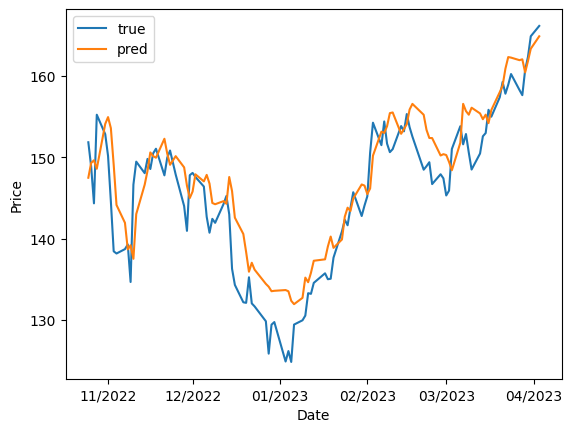

4.207677316915817


In [ ]:
data = prep_all_feature(ticker)
y_true, y_pred, cutoff = LSTM_scaled_multi_model(data, lag, train_test_ratio, num_epochs)
plot_pred(y_true, y_pred, data)
print(RMSE(y_true, y_pred))

## All Company

In [17]:
ticker_lst = ["AAPL", "MSFT", "V", "UNH", "JPM", "JNJ", "WMT", "PG", "CVX", "HD"]
lag = 10
start_date = "2018-01-01"
end_date = "2023-04-04"
train_test_ratio = 0.9
num_epochs = 200

In [18]:
def summary(ticker_lst, fill_method):
    df_res = pd.DataFrame(columns=['stock_name', 'rmse_baseline', 'rmse_vader', 'rmse_tb', 'rmse_finbert', 'rmse_flair'])
    for i, ticker in enumerate(ticker_lst):
        print(ticker)
        data = prep_all_feature(ticker, fill_method=fill_method)
        list_model_type = ['baseline', 'vader', 'tb', 'finbert', 'flair']
        list_rmse = list()
        for mdl in list_model_type:
            data_sub = filter_data(data, model_type=mdl)
            y_true, y_pred, cutoff = LSTM_scaled_multi_model(data_sub, lag, train_test_ratio, num_epochs)
            temp_rmse = RMSE(y_true, y_pred)
            list_rmse.append(temp_rmse)
            print(mdl + ": " + str(temp_rmse))
        
        temp = [ticker] + list_rmse
        df_res.loc[i, :] = temp

    # res = {'Company': ticker_lst, 'RMSE': rmse_lst}
    # res = pd.DataFrame(res)

    return df_res



In [23]:
res_ffill = summary(ticker_lst, fill_method='ffill')
res_ffill.to_excel('result_ffill.xlsx')
res_ffill

AAPL
baseline: 3.4748650253708506
vader: 5.101934083222934
tb: 3.348267141414568
finbert: 3.827421035675146
flair: 3.880670700858904
MSFT
baseline: 9.417247907360613
vader: 6.671792684640579
tb: 8.971407443142647
finbert: 7.645138166374369
flair: 6.922825068878039
V
baseline: 3.2561396020960327
vader: 3.2957902226915827
tb: 3.5791768472216083
finbert: 3.598759219858676
flair: 3.3198850180352584
UNH
baseline: 8.439822694733296
vader: 8.707316752388538
tb: 9.395430233983754
finbert: 8.980951929198039
flair: 8.960245291724224
JPM
baseline: 2.437281582700684
vader: 2.542051404444305
tb: 2.9559944355090133
finbert: 2.74403305800182
flair: 2.5404026538637288
JNJ
baseline: 1.7417516822611598
vader: 2.061406889258706
tb: 2.4396516011660943
finbert: 2.6212139681794078
flair: 1.850642516220375
WMT
baseline: 2.2542195305500736
vader: 1.8650113226643967
tb: 1.902771037346608
finbert: 1.8656026265684824
flair: 2.4854362669517434
PG
baseline: 2.45562322031692
vader: 4.286392910846278
tb: 2.783038724

,stock_name,rmse_baseline,rmse_vader,rmse_tb,rmse_finbert,rmse_flair
0,AAPL,3.474865,5.101934,3.348267,3.827421,3.880671
1,MSFT,9.417248,6.671793,8.971407,7.645138,6.922825
2,V,3.25614,3.29579,3.579177,3.598759,3.319885
3,UNH,8.439823,8.707317,9.39543,8.980952,8.960245
4,JPM,2.437282,2.542051,2.955994,2.744033,2.540403
5,JNJ,1.741752,2.061407,2.439652,2.621214,1.850643
6,WMT,2.25422,1.865011,1.902771,1.865603,2.485436
7,PG,2.455623,4.286393,2.783039,2.067233,2.865365
8,CVX,5.402724,7.366298,6.453438,7.286841,6.833429
9,HD,5.964992,6.184448,6.508421,6.608045,6.149055


In [ ]:
res_limit = summary(ticker_lst, fill_method='limit')
res_limit.to_excel('result_limit.xlsx')
res_limit

In [ ]:
res_decay = summary(ticker_lst, fill_method='decay')
res_decay.to_excel('result_decay.xlsx')
res_decay